**Import dataset from Google Drive (EuroSAT)**

In [11]:
!pip install gradio
! gdown --id 1TfLNUsHcLcBsVRRoG9azevxoutUsGlud
! gdown --id 1yxLHauQBxiuOEcUe-_XkVtOfVAm9UySN
! gdown --id 1zh4TiRD_4E67-wGplP85JLmKjybU9LbX
! gdown --id 1vVM3a7qQwkynp-6gMqOvbApC0P57pLky
! gdown --id 1-j-kYSD6SeO5xu3MKVX5ES-Tk1GwMyNf

from zipfile import ZipFile
with ZipFile('EuroSAT.zip','r') as dataset:
  dataset.extractall('EuroSAT_dataset')

! rm 'EuroSAT.zip'

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1TfLNUsHcLcBsVRRoG9azevxoutUsGlud
From (redirected): https://drive.google.com/uc?id=1TfLNUsHcLcBsVRRoG9azevxoutUsGlud&confirm=t&uuid=06bae63b-03ed-40f6-b07d-38aa8c8046e3
To: /content/EuroSAT.zip
100% 95.4M/95.4M [00:00<00:00, 114MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1yxLHauQBxiuOEcUe-_XkVtOfVAm9UySN
To: /content/resnet_image_classifier.h5
100% 59.2M/59.2M [00:00<00:00, 68.9MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` w

**Deep Learning Algorithm - ResNet Architecture**

In [5]:
import os
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Add, ReLU, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import pickle

# Paths and constants
dataset_path = '/content/EuroSAT_dataset/EuroSAT'

def load_label_map(dataset_path):
    """Load label map from JSON and return mappings."""
    with open(os.path.join(dataset_path, 'label_map.json'), 'r') as f:
        label_map = json.load(f)
    label_map_inv = {v: k for k, v in label_map.items()}
    return label_map, label_map_inv

def load_csv_data(dataset_path):
    """Load train, test, and validation CSV files."""
    train_df = pd.read_csv(os.path.join(dataset_path, 'train.csv'))
    test_df = pd.read_csv(os.path.join(dataset_path, 'test.csv'))
    val_df = pd.read_csv(os.path.join(dataset_path, 'validation.csv'))
    return train_df, test_df, val_df

def load_images_and_labels(df, dataset_path, label_map_inv, image_col='Filename', label_col='Label'):
    """Load images and labels from a DataFrame."""
    images = []
    labels = []
    for _, row in df.iterrows():
        image_path = os.path.join(dataset_path, row[image_col])
        image = plt.imread(image_path)
        images.append(image)
        labels.append(label_map_inv[row[label_col]])  # Convert integer label to class name
    return np.array(images), np.array(labels)

def preprocess_data(images, labels, label_map):
    """Normalize images and one-hot encode labels."""
    images = images / 255.0  # Scale pixel values to [0, 1]
    labels_encoded = np.array([label_map[label] for label in labels])  # Convert labels to integers
    labels_one_hot = to_categorical(labels_encoded)  # One-hot encode labels
    return images, labels_one_hot

def residual_block(x, filters, stride=1):
    """Define a residual block."""
    shortcut = x
    x = Conv2D(filters, (3, 3), strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

def build_resnet(input_shape, num_classes):
    """Build and return a ResNet-like model."""
    inputs = Input(shape=input_shape)

    # Initial Conv layer
    x = Conv2D(64, (7, 7), strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Residual blocks
    x = residual_block(x, 64, stride=1)
    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 512, stride=2)

    # Global Average Pooling and Dense layers
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

def plot_training_history(history):
    """Plot training and validation accuracy and loss."""
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

def summarize_history(history):
    """Print a summary table of training and validation performance."""
    print(f"{'Metric':<15}{'Train':<15}{'Validation':<15}")
    for key in history.history:
        if 'val' not in key:
            val_key = f"val_{key}"
            print(f"{key:<15}{history.history[key][-1]:<15.4f}{history.history[val_key][-1]:<15.4f}")

# Main flow
if __name__ == '__main__':
    # Load label map and CSV data
    label_map, label_map_inv = load_label_map(dataset_path)
    train_df, test_df, val_df = load_csv_data(dataset_path)

    # Load images and labels for train, test, and validation sets
    X_train, y_train = load_images_and_labels(train_df, dataset_path, label_map_inv)
    X_test, y_test = load_images_and_labels(test_df, dataset_path, label_map_inv)
    X_val, y_val = load_images_and_labels(val_df, dataset_path, label_map_inv)

    # Preprocess data (normalize images and one-hot encode labels)
    X_train, y_train_one_hot = preprocess_data(X_train, y_train, label_map)
    X_test, y_test_one_hot = preprocess_data(X_test, y_test, label_map)
    X_val, y_val_one_hot = preprocess_data(X_val, y_val, label_map)

    # Build ResNet model
    input_shape = X_train.shape[1:]  # Image shape (height, width, channels)
    num_classes = len(label_map)
    model = build_resnet(input_shape, num_classes)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Print model summary
    model.summary()

    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model with early stopping
    history = model.fit(X_train, y_train_one_hot, epochs=10, batch_size=32, validation_data=(X_val, y_val_one_hot), callbacks=[early_stopping])

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, y_test_one_hot)
    print(f'Test Accuracy: {test_accuracy:.4f}')

    # Plot training history
    plot_training_history(history)

    # Summarize training history
    summarize_history(history)

    additional_details = {
      'X_test': X_test,                  # Add entire test dataset
      'y_test_one_hot': y_test_one_hot,  # Add test labels (one-hot encoded)
      'label_map': label_map             # Label map used for decoding
    }

    # Update the history data with the new details
    history.history.update(additional_details)

    # Save the model and training history
    model.save('resnet_image_classifier.h5')
    with open('history_resnet.pkl', 'wb') as f:
        pickle.dump(history.history, f)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 64)     │          9,472 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 32, 32, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 64)     │              0 │ re_lu[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 16, 16, 64)     │         36,928 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 16, 16, 64)     │            256 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 16, 16, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 16, 16, 64)     │         36,928 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 16, 16, 64)     │            256 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 16, 16, 64)     │              0 │ batch_normalization_2… │
│                           │                        │                │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 16, 16, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 8, 8, 128)      │         73,856 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 8, 8, 128)      │            512 │ conv2d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 8, 8, 128)      │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 8, 8, 128)      │        147,584 │ re_lu_3[0][0]          │
├──────────────────────

 Total params: 4,919,562 (18.77 MB)

 Trainable params: 4,913,802 (18.74 MB)

 Non-trainable params: 5,760 (22.50 KB)

KeyboardInterrupt: 

**Deep Learning Algorithm - CNN**

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 684,490 (2.61 MB)

 Trainable params: 684,490 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 142s 237ms/step - accuracy: 0.4012 - loss: 1.5295 - val_accuracy: 0.6624 - val_loss: 0.9417
Epoch 2/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 138s 231ms/step - accuracy: 0.6863 - loss: 0.8707 - val_accuracy: 0.7328 - val_loss: 0.7435
Epoch 3/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 143s 234ms/step - accuracy: 0.7501 - loss: 0.6883 - val_accuracy: 0.7391 - val_loss: 0.7452
Epoch 4/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 141s 232ms/step - accuracy: 0.7771 - loss: 0.6150 - val_accuracy: 0.8254 - val_loss: 0.4944
Epoch 5/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 137s 231ms/step - accuracy: 0.8028 - loss: 0.5390 - val_accuracy: 0.7587 - val_loss: 0.6423
Epoch 6/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 142s 231ms/step - accuracy: 0.8395 - loss: 0.4480 - val_accuracy: 0.8141 - val_loss: 0.5024
Epoch 7/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 136s 230ms/step - accuracy: 0.8544 - loss: 0.4071 - val_accuracy: 0.8143 - val_loss: 0.5170
Epoch 8/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 135s 229ms/step - accuracy: 0.8652 -

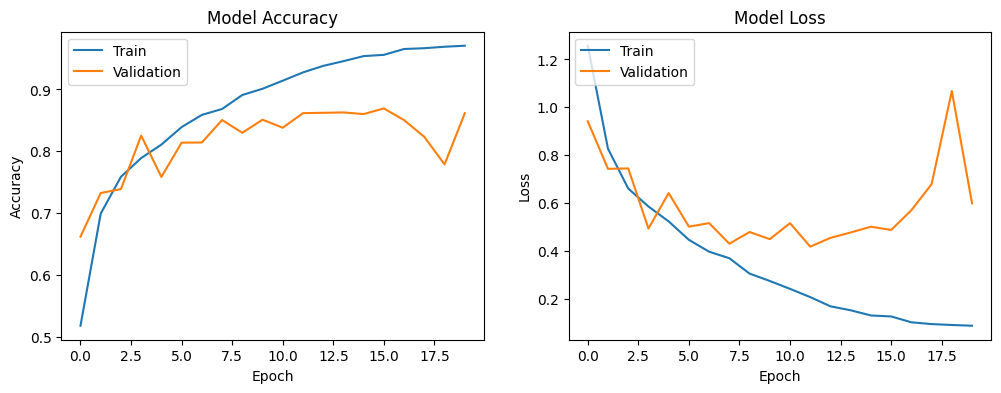

Metric         Train          Validation     
accuracy       0.9705         0.8615         
loss           0.0890         0.5991         


AttributeError: 'History' object has no attribute 'update'

In [8]:
import os
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import pickle

# Paths and constants
dataset_path = '/content/EuroSAT_dataset/EuroSAT'

def load_label_map(dataset_path):
    """Load label map from JSON and return mappings."""
    with open(os.path.join(dataset_path, 'label_map.json'), 'r') as f:
        label_map = json.load(f)
    label_map_inv = {v: k for k, v in label_map.items()}
    return label_map, label_map_inv

def load_csv_data(dataset_path):
    """Load train, test, and validation CSV files."""
    train_df = pd.read_csv(os.path.join(dataset_path, 'train.csv'))
    test_df = pd.read_csv(os.path.join(dataset_path, 'test.csv'))
    val_df = pd.read_csv(os.path.join(dataset_path, 'validation.csv'))
    return train_df, test_df, val_df

def load_images_and_labels(df, dataset_path, label_map_inv, image_col='Filename', label_col='Label'):
    """Load images and labels from a DataFrame."""
    images = []
    labels = []
    for _, row in df.iterrows():
        image_path = os.path.join(dataset_path, row[image_col])
        image = plt.imread(image_path)
        images.append(image)
        labels.append(label_map_inv[row[label_col]])  # Convert integer label to class name
    return np.array(images), np.array(labels)

def preprocess_data(images, labels, label_map):
    """Normalize images and one-hot encode labels."""
    images = images / 255.0  # Scale pixel values to [0, 1]
    labels_encoded = np.array([label_map[label] for label in labels])  # Convert labels to integers
    labels_one_hot = to_categorical(labels_encoded)  # One-hot encode labels
    return images, labels_one_hot

def build_cnn_model(input_shape, num_classes):
    """Build and return a CNN model."""
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

def plot_training_history(history):
    """Plot training and validation accuracy and loss."""
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

def summarize_history(history):
    """Print a summary table of training and validation performance."""
    print(f"{'Metric':<15}{'Train':<15}{'Validation':<15}")
    for key in history.history:
        if 'val' not in key:
            val_key = f"val_{key}"
            print(f"{key:<15}{history.history[key][-1]:<15.4f}{history.history[val_key][-1]:<15.4f}")

# Main flow
if __name__ == '__main__':
    # Load label map and CSV data
    label_map, label_map_inv = load_label_map(dataset_path)
    train_df, test_df, val_df = load_csv_data(dataset_path)

    # Load images and labels for train, test, and validation sets
    X_train, y_train = load_images_and_labels(train_df, dataset_path, label_map_inv)
    X_test, y_test = load_images_and_labels(test_df, dataset_path, label_map_inv)
    X_val, y_val = load_images_and_labels(val_df, dataset_path, label_map_inv)

    # Preprocess data (normalize images and one-hot encode labels)
    X_train, y_train_one_hot = preprocess_data(X_train, y_train, label_map)
    X_test, y_test_one_hot = preprocess_data(X_test, y_test, label_map)
    X_val, y_val_one_hot = preprocess_data(X_val, y_val, label_map)

    # Build CNN model
    input_shape = X_train.shape[1:]  # Image shape (height, width, channels)
    num_classes = len(label_map)
    model = build_cnn_model(input_shape, num_classes)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Print model summary
    model.summary()

    # Train the model
    history = model.fit(X_train, y_train_one_hot, epochs=20, batch_size=32, validation_data=(X_val, y_val_one_hot))

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, y_test_one_hot)
    print(f'Test Accuracy: {test_accuracy:.4f}')

    # Plot training history
    plot_training_history(history)

    # Summarize training history
    summarize_history(history)

    additional_details = {
      'X_test': X_test,                  # Add entire test dataset
      'y_test_one_hot': y_test_one_hot,  # Add test labels (one-hot encoded)
      'label_map': label_map             # Label map used for decoding
    }

    # Update the history data with the new details
    history.history.update(additional_details)

    # Save the model and training history
    model.save('cnn_image_classifier.h5')
    with open('history.pkl', 'wb') as f:
        pickle.dump(history.history, f)


**Model Evaluation (Confusion Matrix & ROC Curve)**

85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step


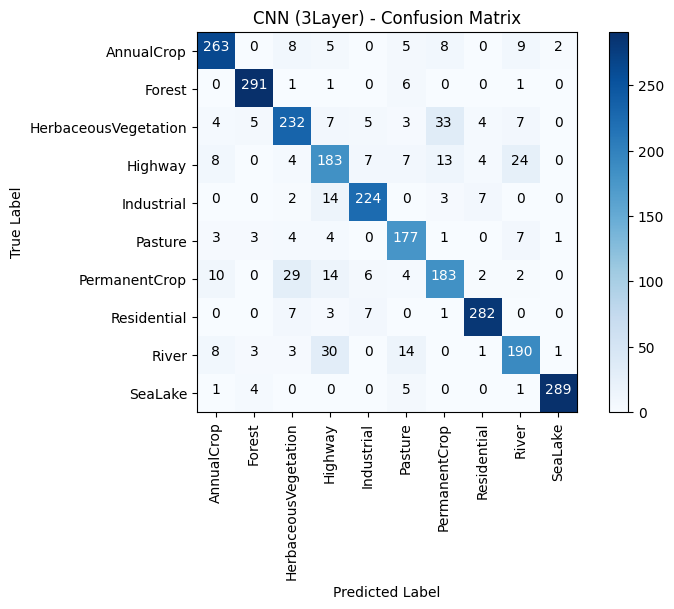

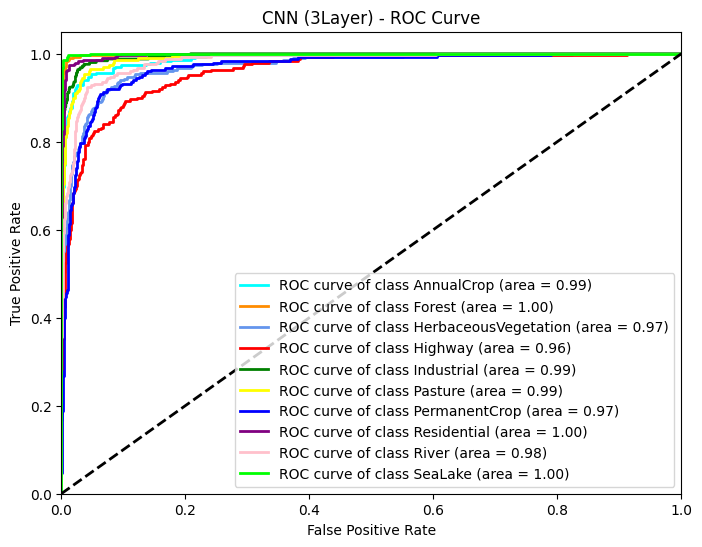

85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step


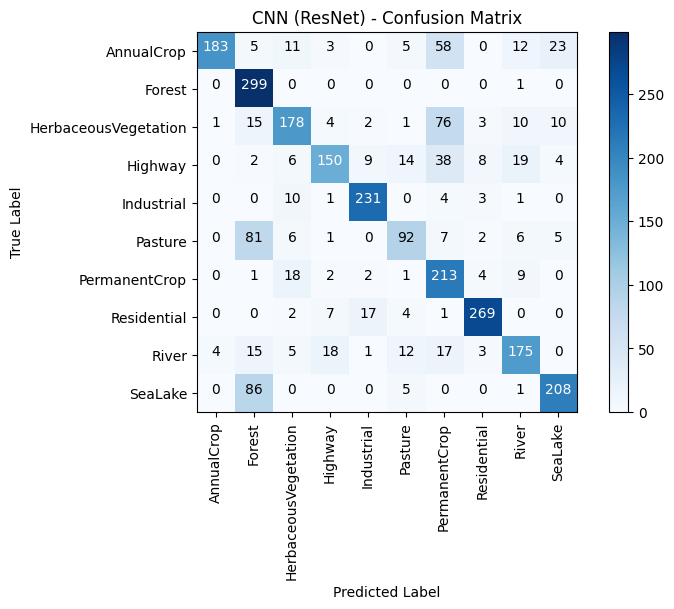

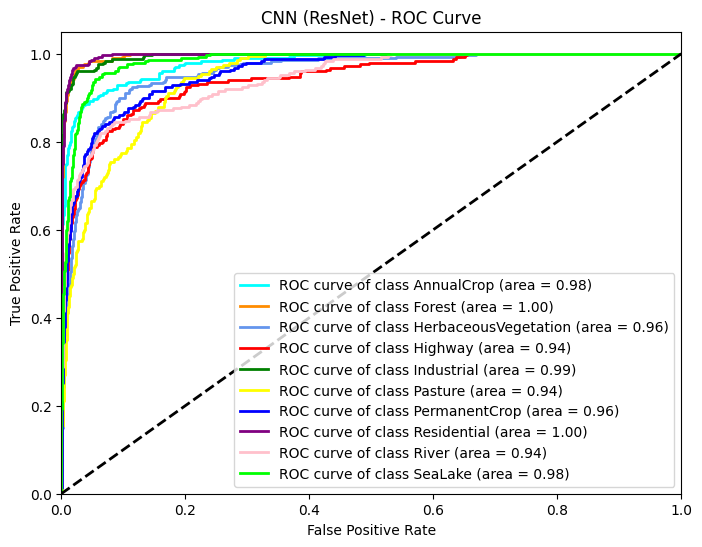

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import pickle

def evaluate_model(model, X_test, y_test_one_hot, label_map, model_name):
    """Evaluates the model using a confusion matrix and ROC curve."""

    # Predict probabilities for each class
    y_pred_probs = model.predict(X_test)

    # Convert probabilities to class predictions
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true_classes = np.argmax(y_test_one_hot, axis=1)


    # Confusion Matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(label_map))
    plt.xticks(tick_marks, label_map.keys(), rotation=90)
    plt.yticks(tick_marks, label_map.keys())

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # ROC Curve (Binary Classification)
    # Binarize the output
    y_test_bin = label_binarize(y_true_classes, classes=list(range(len(label_map))))
    n_classes = y_test_bin.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curve for each class
    plt.figure(figsize=(8, 6))
    lw = 2
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'yellow', 'blue', 'purple', 'pink', 'lime'])  # Add more colors as needed

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(list(label_map.keys())[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Load the saved models and history if needed
from tensorflow.keras.models import load_model
cnn_model = load_model('/content/cnn_image_classifier.h5')
cnn_resnet_model = load_model('/content/resnet_image_classifier.h5')

# Load existing history.pkl file
with open('history.pkl', 'rb') as f:
    history_data = pickle.load(f)

# Load existing history.pkl file
with open('history_resnet.pkl', 'rb') as f_resnet:
    history_resnet_data = pickle.load(f_resnet)

# Evaluate CNN model
evaluate_model(cnn_model, history_data['X_test'], history_data['y_test_one_hot'], history_data['label_map'], "CNN (3Layer)")

# Evaluate LSTM model
evaluate_model(cnn_resnet_model, history_resnet_data['X_test'], history_resnet_data['y_test_one_hot'], history_resnet_data['label_map'], "CNN (ResNet)")

**User Interface using Gradio**

In [13]:
import cv2
import gradio as gr
import numpy as np
from tensorflow.keras.models import load_model
import json

# Load the saved models
cnn_model = load_model('/content/cnn_image_classifier.h5')
resnet_model = load_model('/content/resnet_image_classifier.h5')

# Load label map (assuming you have it defined or loaded elsewhere)
# Replace with your actual loading method
with open('/content/EuroSAT_dataset/EuroSAT/label_map.json', 'r') as f:
    label_map = json.load(f)
label_map_inv = {v: k for k, v in label_map.items()}


def predict_image(image):
    # Preprocess the image (resize, normalize, etc.)
    image = cv2.resize(image, (64, 64))
    image = image / 255.0
    image = np.expand_dims(image, axis=0)

    # Make predictions with both models
    cnn_pred = cnn_model.predict(image)[0]
    resnet_pred = resnet_model.predict(image)[0]

    # Get top 5 predictions for CNN
    cnn_top5_indices = np.argsort(cnn_pred)[::-1][:5]
    cnn_top5 = {
        label_map_inv[idx]: float(cnn_pred[idx]) for idx in cnn_top5_indices
    }

    # Get top 5 predictions for ResNet
    resnet_top5_indices = np.argsort(resnet_pred)[::-1][:5]
    resnet_top5 = {
        label_map_inv[idx]: float(resnet_pred[idx]) for idx in resnet_top5_indices
    }

    # Final predictions
    cnn_final_prediction = label_map_inv[np.argmax(cnn_pred)]
    resnet_final_prediction = label_map_inv[np.argmax(resnet_pred)]

    return cnn_top5, cnn_final_prediction, resnet_top5, resnet_final_prediction


iface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="numpy"),
    outputs=[
        gr.Label(num_top_classes=5, label="CNN Top 5 Predictions"),
        gr.Textbox(label="CNN Final Prediction"),
        gr.Label(num_top_classes=5, label="ResNet Top 5 Predictions"),
        gr.Textbox(label="ResNet Final Prediction"),
    ],
    title="Image Classification with CNN and ResNet",
    description="Upload an image to classify using two different models.",
)

iface.launch(debug=True)


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://56a8d1f40a4ee43129.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://56a8d1f40a4ee43129.gradio.live
